# Data Exploration and Augmentation

This notebook explores the LFW (Labeled Faces in the Wild) dataset and implements data augmentation strategies for facial recognition.

## Objectives:
- Load and explore the facial recognition dataset
- Visualize sample images across different identities
- Implement robust augmentation techniques
- Create balanced training/validation/test splits

## 1. Import Libraries

Import necessary libraries for data processing, visualization, and augmentation.

In [1]:
import warnings
warnings.filterwarnings("ignore")  

import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import albumentations as A
import mlflow

from collections import Counter


In [2]:
MLFLOW_EXPERIMENT = "facial_recognition_data_pipeline"
mlflow.set_experiment(MLFLOW_EXPERIMENT)
mlflow.set_tag("notebook", "01_data_exploration_and_augmentation")

## 2. Load Dataset

Load images from the LFW dataset directory and extract person labels from folder names.

In [3]:
DATA_PATH = "../LFW/lfw-deepfunneled/lfw-deepfunneled"

images = []
labels = []

for person in os.listdir(DATA_PATH):
    person_path = os.path.join(DATA_PATH, person)
    if not os.path.isdir(person_path):
        continue
    for img_name in os.listdir(person_path):
        img_path = os.path.join(person_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(person)

print("Total images loaded:", len(images))
print("Total classes:", len(set(labels)))

Total images loaded: 13233
Total classes: 5749


## 3. Preprocess Images

Resize all images to a standard size and normalize pixel values to [0, 1] range. Encode class labels as integers.

In [4]:
# Filter out classes with fewer than 5 images
label_counts = Counter(labels)
valid_labels = [label for label, count in label_counts.items() if count >= 5]

# Keep only images belonging to valid labels
filtered_images = []
filtered_labels = []

for img, label in zip(images, labels):
    if label in valid_labels:
        filtered_images.append(img)
        filtered_labels.append(label)

print(f"Original: {len(images)} images, {len(set(labels))} classes")
print(f"Filtered: {len(filtered_images)} images, {len(set(filtered_labels))} classes")
print(f"Removed: {len(set(labels)) - len(set(filtered_labels))} classes with < 5 images")

# Update images and labels
images = filtered_images
labels = filtered_labels

# rescale and normalize size of images to be between 0 and 1
IMG_SIZE = 128
X = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) for img in images], dtype=np.float32)
X = X / 255.0  

# Encode class labels
le = LabelEncoder()
Y = le.fit_transform(labels)

print("Shape:", X.shape)
print("Labels encoded:", len(np.unique(Y)))

Original: 13233 images, 5749 classes
Filtered: 5985 images, 423 classes
Removed: 5326 classes with < 5 images
Shape: (5985, 128, 128, 3)
Labels encoded: 423
Shape: (5985, 128, 128, 3)
Labels encoded: 423


## 4. Visualize Random Samples

Display a grid of random faces from the dataset to understand data diversity and quality.

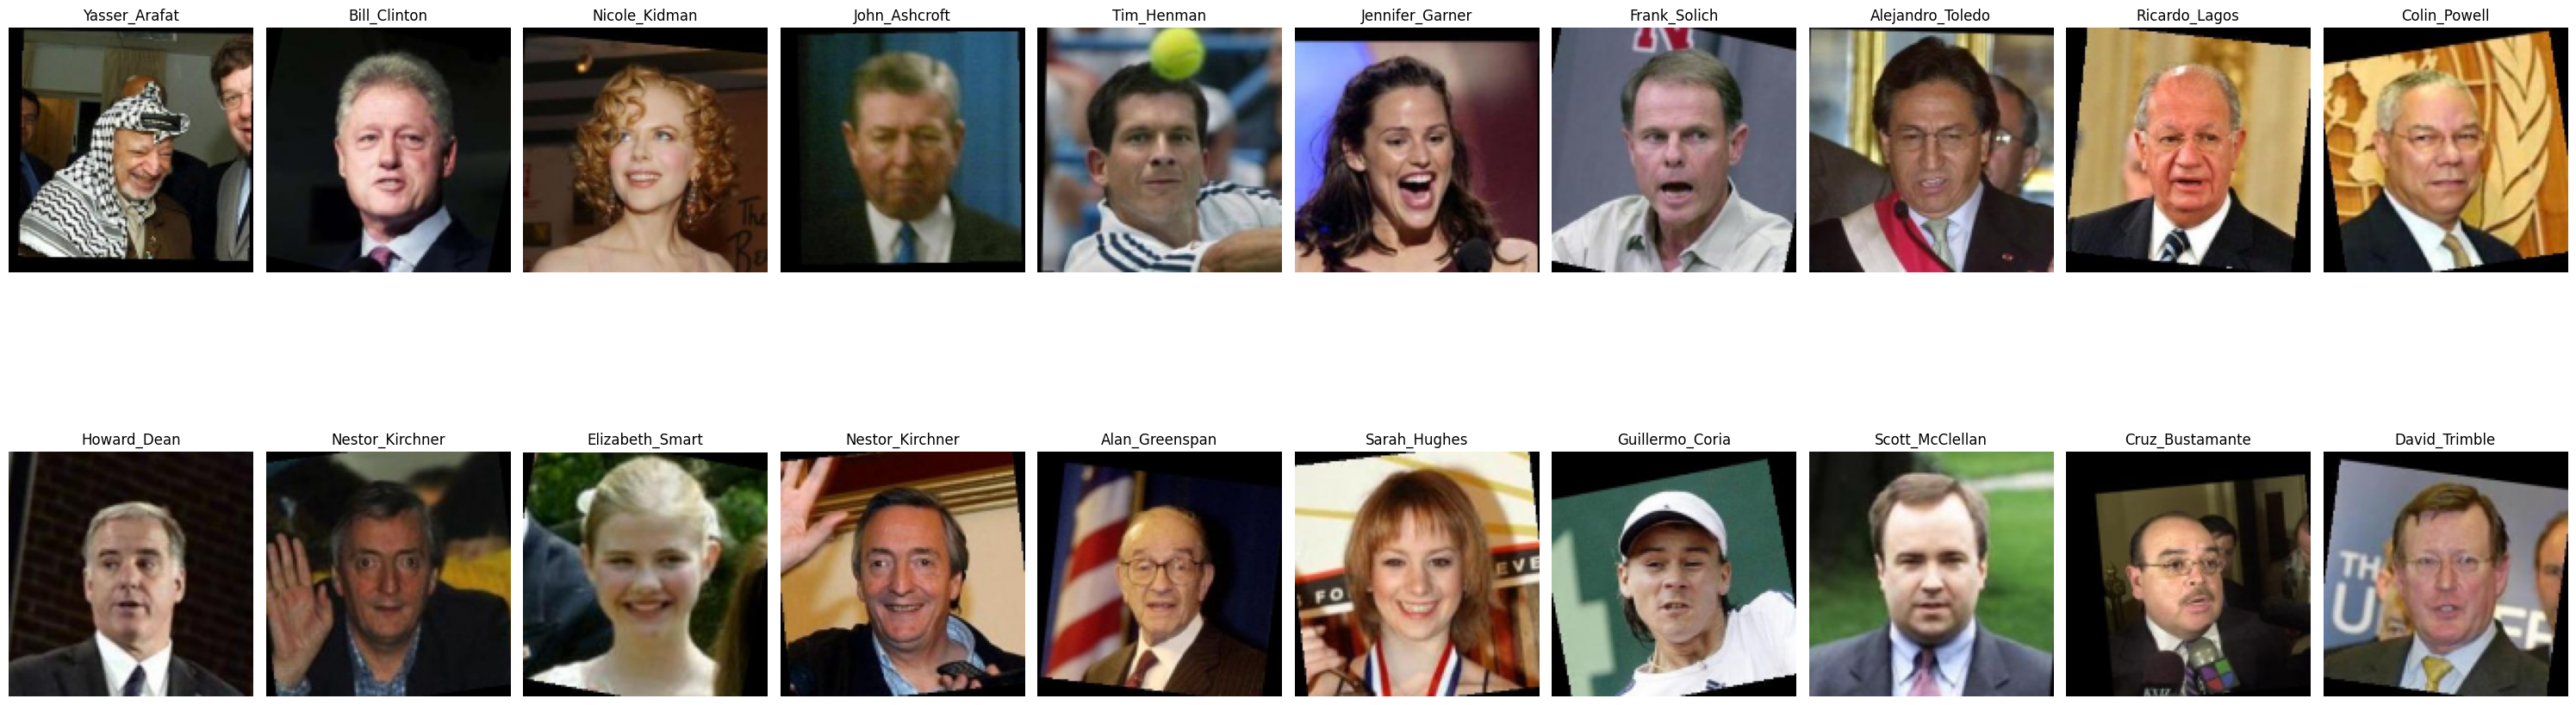

In [5]:
def show_random_images_with_names_grid(n=20, rows=2):
    cols = n // rows
    plt.figure(figsize=(30, 6 * rows))
    for i in range(n):
        idx = random.randint(0, len(X)-1)
        img = (X[idx] * 255).astype(np.uint8)
        real_name = le.inverse_transform([Y[idx]])[0]
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(real_name, fontsize=12)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_random_images_with_names_grid(n=20, rows=2)

## 5. Define Augmentation Pipeline

Create an augmentation pipeline using Albumentations to simulate real-world variations:
- **Horizontal Flip**: Mirror faces for left/right variations
- **Rotation**: Simulate head tilts (±15 degrees)
- **Brightness/Contrast**: Handle different lighting conditions
- **Blur & Noise**: Account for camera quality variations
- **Scale**: Simulate different distances from camera
- **Dropout**: Handle partial occlusions (glasses, masks, etc.)

In [6]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),  
    A.Rotate(limit=15, p=0.5),  
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
    A.GaussianBlur(blur_limit=(1, 3), p=0.3),
    A.GaussNoise(var_limit=(5, 15), p=0.3),  
    A.RandomScale(scale_limit=0.1, p=0.3),  
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),  
])

def apply_aug(img):
    return augment(image=img)["image"]

## 6. Compare Original vs Augmented Images

Visualize the effect of augmentation by comparing original and augmented versions side-by-side.

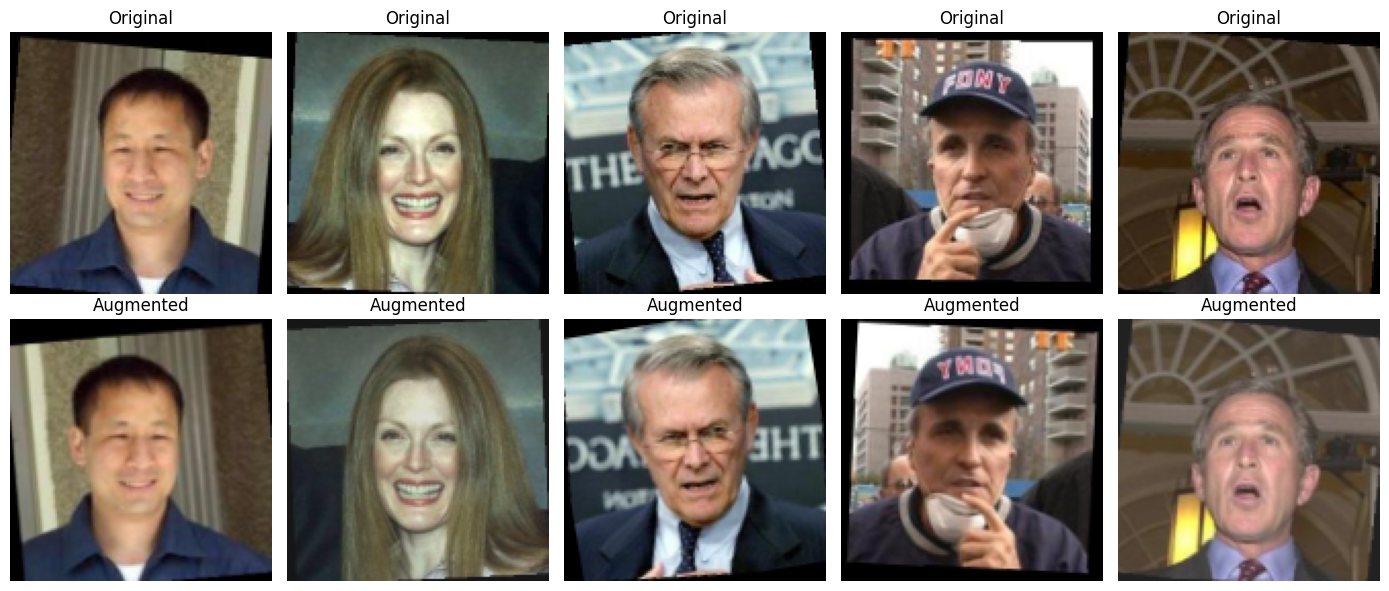

In [7]:
def show_augmentation_comparison(n=5):
    """Display original vs augmented images side by side"""
    plt.figure(figsize=(14, 6))
    for i in range(n):
        idx = random.randint(0, len(X)-1)
        original = (X[idx] * 255).astype(np.uint8)
        augmented = apply_aug(original)
        
        plt.subplot(2, n, i+1)
        plt.imshow(original)
        plt.title("Original")
        plt.axis("off")
        
        plt.subplot(2, n, i+1+n)
        plt.imshow(augmented)
        plt.title("Augmented")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_augmentation_comparison(5)

## 7. Multiple Augmentations of Same Face

Show multiple different augmentations of the same person to demonstrate variation diversity.

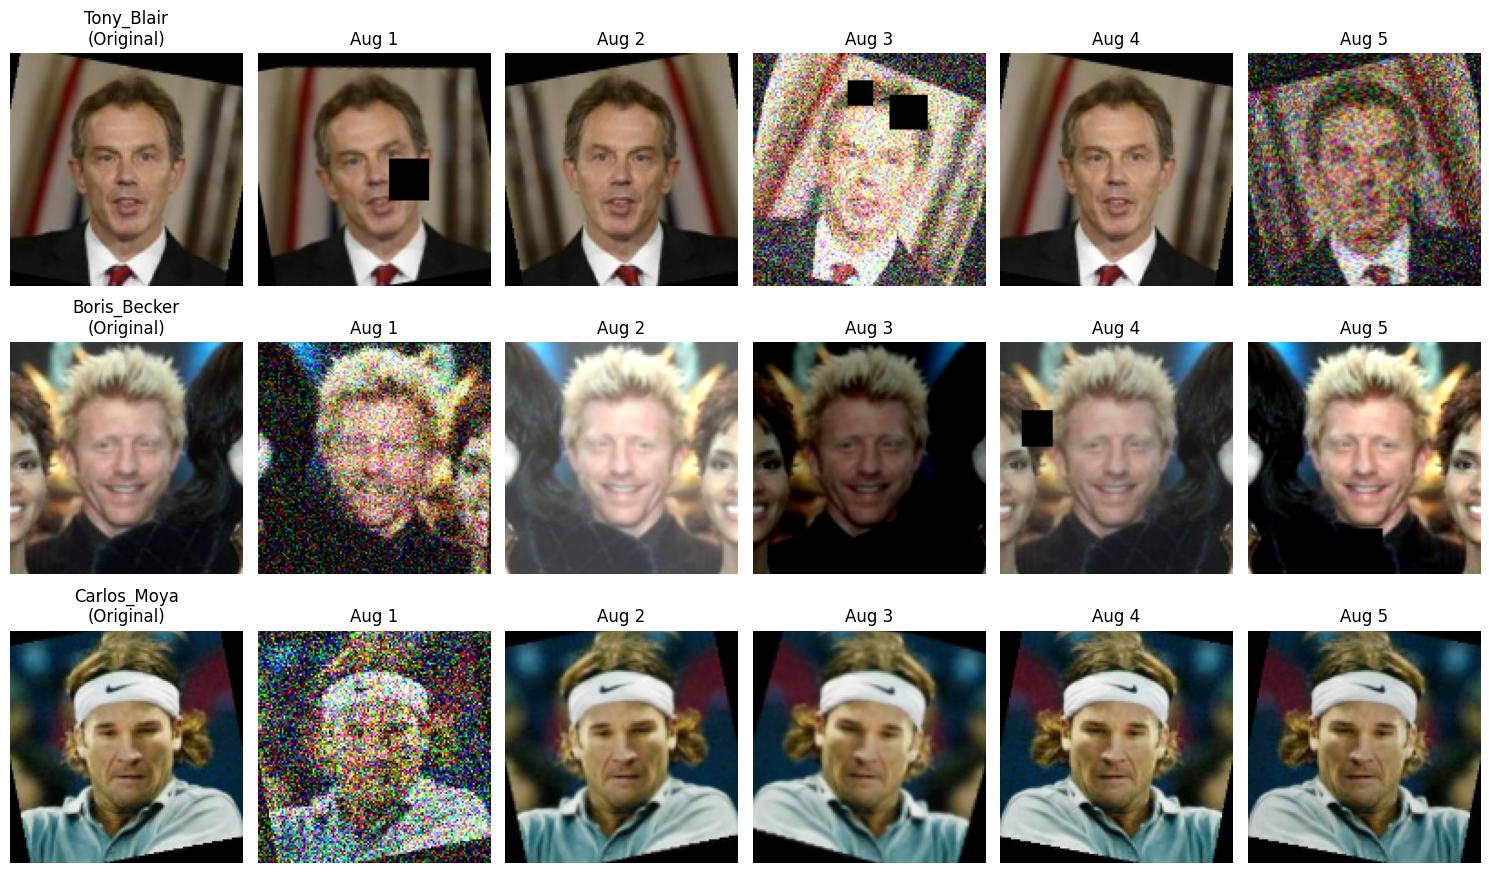

In [8]:
def show_multiple_augmentations(num_samples=3, aug_per_sample=5):
    """Display one face with multiple different augmentations"""
    plt.figure(figsize=(15, 3 * num_samples))
    
    for sample_idx in range(num_samples):
        idx = random.randint(0, len(X)-1)
        original = (X[idx] * 255).astype(np.uint8)
        person_name = le.inverse_transform([Y[idx]])[0]
        
        # Show original
        plt.subplot(num_samples, aug_per_sample + 1, sample_idx * (aug_per_sample + 1) + 1)
        plt.imshow(original)
        plt.title(f"{person_name}\n(Original)")
        plt.axis("off")
        
        # Show augmented versions
        for aug_idx in range(aug_per_sample):
            augmented = apply_aug(original)
            plt.subplot(num_samples, aug_per_sample + 1, sample_idx * (aug_per_sample + 1) + aug_idx + 2)
            plt.imshow(augmented)
            plt.title(f"Aug {aug_idx + 1}")
            plt.axis("off")
    
    plt.tight_layout()
    plt.show()

show_multiple_augmentations(num_samples=3, aug_per_sample=5)

## 8. Create Augmented Dataset

Generate augmented samples to balance the dataset, ensuring each identity has a minimum number of training samples. This improves model robustness and generalization.

**Strategy**: For each identity with fewer than target samples, generate synthetic variations using the augmentation pipeline.

In [9]:
def create_augmented_dataset(X, Y, target_samples_per_class=10):
   
    X_aug = []
    Y_aug = []
    
    unique_labels = np.unique(Y)
    
    for label in unique_labels:
        # Get all samples for this identity
        indices = np.where(Y == label)[0]
        class_samples = X[indices]
        
        # Add all original samples
        for sample in class_samples:
            X_aug.append(sample)
            Y_aug.append(label)
        
        # Calculate how many augmented samples we need
        current_count = len(class_samples)
        needed = max(0, target_samples_per_class - current_count)
        
        # Generate augmented samples
        for _ in range(needed):
            # Pick a random original from this class
            src_img = class_samples[random.randint(0, len(class_samples)-1)]
            # Convert to uint8 for augmentation
            src_uint8 = (src_img * 255).astype(np.uint8)
            # Apply augmentation
            aug_img = apply_aug(src_uint8)
            # Ensure consistent size after augmentation (RandomScale may resize)
            aug_img = cv2.resize(aug_img, (IMG_SIZE, IMG_SIZE))
            # Convert back to float32 [0,1]
            aug_float = aug_img.astype(np.float32) / 255.0
            
            X_aug.append(aug_float)
            Y_aug.append(label)
    
    return np.array(X_aug, dtype=np.float32), np.array(Y_aug, dtype=np.int64)

# Generate augmented dataset (this may take a while)
print("Creating augmented dataset...")
X_augmented, Y_augmented = create_augmented_dataset(X, Y, target_samples_per_class=10)

print(f"Original dataset: {len(X)} images")
print(f"Augmented dataset: {len(X_augmented)} images")
print(f"Number of classes: {len(np.unique(Y_augmented))}")

Creating augmented dataset...
Original dataset: 5985 images
Augmented dataset: 6974 images
Number of classes: 423
Original dataset: 5985 images
Augmented dataset: 6974 images
Number of classes: 423


## 9. Split Dataset

Split the augmented dataset into training (70%), validation (15%), and test (15%) sets using stratified sampling to maintain class distribution.

In [10]:
print(f"Total classes: {len(np.unique(Y_augmented))}")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_augmented, Y_augmented,
    test_size=0.3,
    stratify=Y_augmented,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

print(f"Training set: {len(X_train)} images ({len(np.unique(y_train))} classes)")
print(f"Validation set: {len(X_val)} images ({len(np.unique(y_val))} classes)")
print(f"Test set: {len(X_test)} images ({len(np.unique(y_test))} classes)")

Total classes: 423
Training set: 4881 images (423 classes)
Validation set: 1046 images (423 classes)
Test set: 1047 images (423 classes)
Training set: 4881 images (423 classes)
Validation set: 1046 images (423 classes)
Test set: 1047 images (423 classes)


## 10. Visualize Split Samples

Verify the quality and distribution of samples across train/validation/test splits.

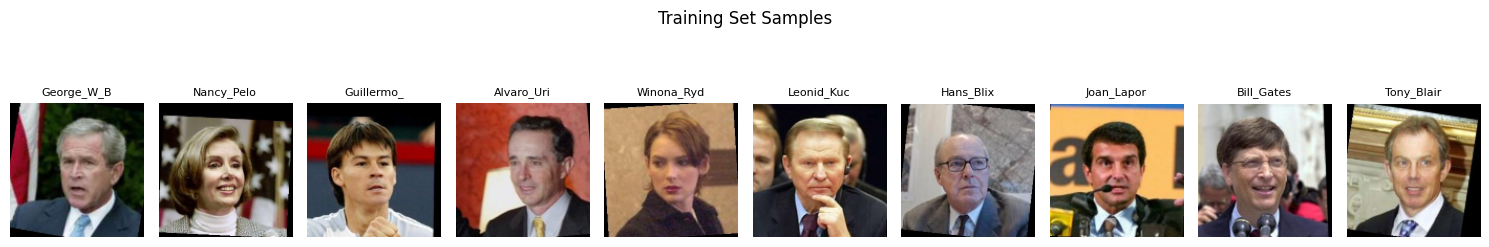

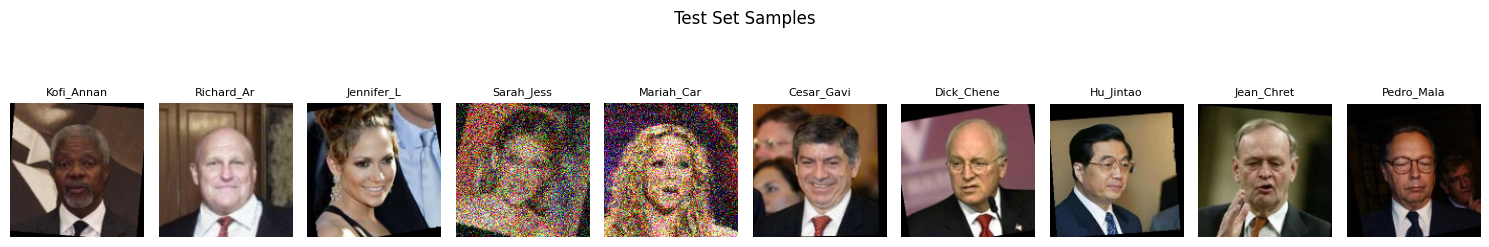

In [11]:
def visualize_split_samples(X, y, split_name, n=10):
    """Show random samples from a data split"""
    plt.figure(figsize=(15, 3))
    for i in range(n):
        idx = random.randint(0, len(X)-1)
        img = (X[idx] * 255).astype(np.uint8)
        label = le.inverse_transform([y[idx]])[0]
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(label[:10], fontsize=8)  # Truncate long names
        plt.axis("off")
    plt.suptitle(f"{split_name} Set Samples", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_split_samples(X_train, y_train, "Training", n=10)
visualize_split_samples(X_val, y_val, "Validation", n=10)
visualize_split_samples(X_test, y_test, "Test", n=10)

## 11. Export Processed Data

Save the preprocessed and split datasets along with the label encoder for use in model training notebooks.

In [12]:
import pickle

# Create data directory if it doesn't exist
data_dir = os.path.join("..", "data")
os.makedirs(data_dir, exist_ok=True)

# Save training data
np.save(os.path.join(data_dir, "X_train.npy"), X_train)
np.save(os.path.join(data_dir, "y_train.npy"), y_train)

# Save validation data
np.save(os.path.join(data_dir, "X_val.npy"), X_val)
np.save(os.path.join(data_dir, "y_val.npy"), y_val)

# Save test data
np.save(os.path.join(data_dir, "X_test.npy"), X_test)
np.save(os.path.join(data_dir, "y_test.npy"), y_test)

# Save label encoder
with open(os.path.join(data_dir, "label_encoder.pkl"), "wb") as f:
    pickle.dump(le, f)

# Save metadata
metadata = {
    "img_size": IMG_SIZE,
    "num_classes": len(np.unique(y_train)),
    "train_samples": len(X_train),
    "val_samples": len(X_val),
    "test_samples": len(X_test),
    "class_names": le.classes_.tolist()
}

with open(os.path.join(data_dir, "metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)

print("Data exported successfully!")
print("Files saved:")
print(f"   - X_train.npy ({X_train.shape})")
print(f"   - y_train.npy ({y_train.shape})")
print(f"   - X_val.npy ({X_val.shape})")
print(f"   - y_val.npy ({y_val.shape})")
print(f"   - X_test.npy ({X_test.shape})")
print(f"   - y_test.npy ({y_test.shape})")
print(f"   - label_encoder.pkl")
print(f"   - metadata.pkl")

Data exported successfully!
Files saved:
   - X_train.npy ((4881, 128, 128, 3))
   - y_train.npy ((4881,))
   - X_val.npy ((1046, 128, 128, 3))
   - y_val.npy ((1046,))
   - X_test.npy ((1047, 128, 128, 3))
   - y_test.npy ((1047,))
   - label_encoder.pkl
   - metadata.pkl


In [13]:
data_dir = os.path.join("..", "data")

active_run = mlflow.active_run()
if active_run is not None:
    mlflow.end_run()

with mlflow.start_run(run_name="data_preparation"):
    mlflow.log_param("image_size", IMG_SIZE)
    mlflow.log_param("target_samples_per_class", 10)
    mlflow.log_metric("train_samples", float(len(X_train)))
    mlflow.log_metric("val_samples", float(len(X_val)))
    mlflow.log_metric("test_samples", float(len(X_test)))
    mlflow.log_metric("num_classes", float(len(np.unique(y_train))))
    metadata_path = os.path.join(data_dir, "metadata.pkl")
    if os.path.exists(metadata_path):
        mlflow.log_artifact(metadata_path)
    label_encoder_path = os.path.join(data_dir, "label_encoder.pkl")
    if os.path.exists(label_encoder_path):
        mlflow.log_artifact(label_encoder_path)

## Summary

- Dataset loaded and preprocessed  
- Augmentation pipeline configured  
- Balanced dataset created with synthetic samples  
- Train/validation/test splits prepared  
